In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


In [3]:
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

s(3.04) for the first system: 0.9999999999999994
s(3.04) for the second system: 1.0000235249246123


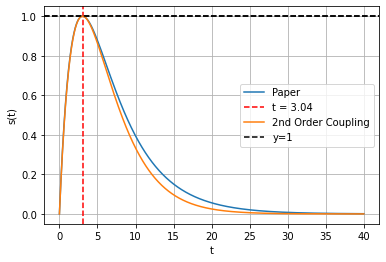

In [4]:
def dxdt(t, x, tau_r, tau_f):
    a = x[0]
    b = x[1]
    return [-a / tau_r, -b / tau_f]

t0 = 0
tfinal = 40
dt = 0.01
t = np.linspace(0, tfinal, 1000)

f = 3.0713828029683845  # Found to be correct value
x0 = [f, f]

sol1 = solve_ivp(dxdt, [t0, tfinal], x0, args=(2, 5), dense_output=True)

a = sol1.sol(t)[0]
b = sol1.sol(t)[1]

s1 = b - a

# Calculate s(4.03) for the first system
s1_at_4_03 = sol1.sol(3.043043043043043)[1] - sol1.sol(3.043043043043043)[0]
print(f"s(3.04) for the first system: {s1_at_4_03}")

# Plot for the first system
plt.plot(t, s1, label='Paper')
plt.ylabel('s(t)')
plt.xlabel('t')
plt.grid(True)
plt.axhline(1, color='k', linestyle='--')
plt.axvline(3.043043043043043, color='r', linestyle='--', label='t = 3.04')

# Second system
def dxdt_new(t, x, tau_s):
    s = x[0]
    p = x[1]
#     dsdt = -s / 2 + p / 2
#     dpdt = -p / 5
    dsdt = -s / 3.043043043043043 + p / 3.043043043043043
    dpdt = -p / 3.043043043043043
    return [dsdt, dpdt]

x0_new = [0, 2.7185823035951033]  # Obtained

sol2 = solve_ivp(dxdt_new, [t0, tfinal], x0_new, args=(5,), dense_output=True)

s2 = sol2.sol(t)[0]

# Calculate s(4.03) for the second system
s2_at_4_03 = sol2.sol(3.043043043043043)[0]
print(f"s(3.04) for the second system: {s2_at_4_03}")

# Plot for the second system
plt.plot(t, s2, label='2nd Order Coupling')
plt.axhline(1, color='k', linestyle='--', label='y=1')
plt.legend()
plt.show()


Average number of connections per neuron: 39.596666666666664
Connectivity Matrix g [[0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.03 0.   ... 0.   0.   0.03]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]]
Average value of matrix g= 0.003959666666666666
Chi measure (synchrony): 0.2665825157974826
Average firing rate 10.45


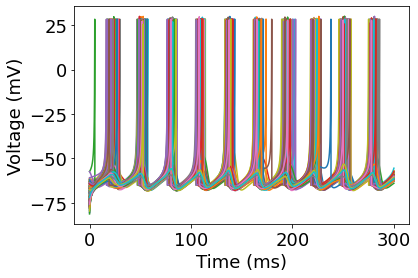

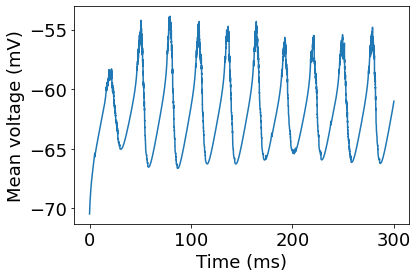

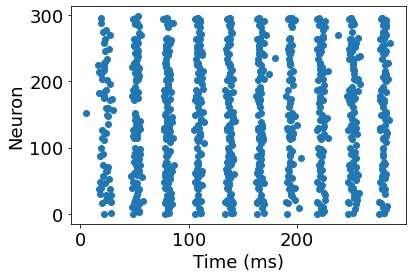

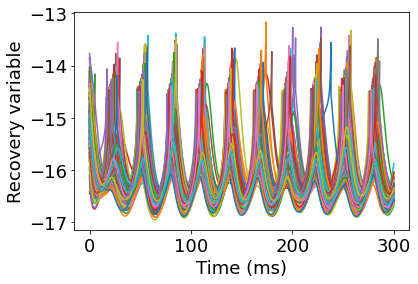

In [16]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:2*N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


[9.066666666666666, 7.6, 6.5, 5.5, 5.383333333333334, 4.816666666666667, 4.35, 3.933333333333333, 4.033333333333333, 3.966666666666667, 3.716666666666667, 3.5, 3.5500000000000003, 3.533333333333333, 3.5, 3.35, 3.416666666666667, 3.3833333333333333, 3.5, 3.3833333333333333]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


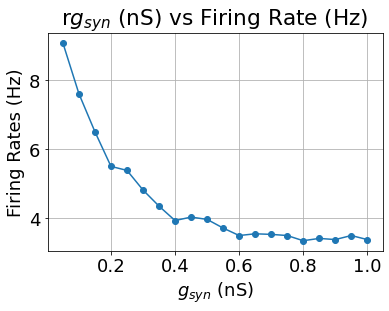

In [6]:
#G_syn vs Firing Rate
connection_strengths = np.linspace(0.05, 1, 20)  # Vary connection strength from 0.25 to 0.5
firing_rates = []
# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    
    average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
    firing_rates.append(average_firing_rate)
# Plotting the results
plt.figure()
plt.plot(connection_strengths, firing_rates, marker='o', linestyle='-')
plt.xlabel(r'$g_{syn}$ (nS)')
plt.ylabel('Firing Rates (Hz)')
plt.title('r$g_{syn}$ (nS) vs Firing Rate (Hz)')
plt.grid(True)
print(firing_rates)
print(connection_strengths)
plt.show()

[10.65, 8.75, 10.016666666666667, 9.283333333333333, 10.766666666666667, 10.466666666666667, 10.333333333333334, 8.200000000000001, 8.5, 6.2, 6.866666666666667, 6.1000000000000005, 5.016666666666667, 4.733333333333333, 3.9, 3.8166666666666664, 3.1, 2.75, 2.3, 2.2333333333333334]
[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]


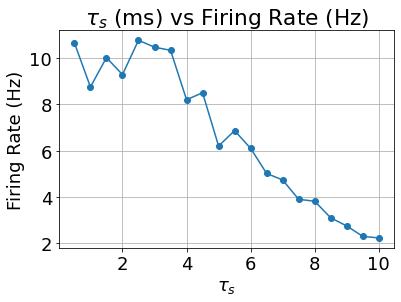

In [7]:
#Tau_S vs Firing Rate
tau_s_values = np.linspace(0.5,10,20)  # Values from 0 to 10 inclusive
firing_rates = []

g = np.zeros((N, N))
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                g[j, i] = 0.03
                    
# Loop over different values of tau_s
for tau_s in tau_s_values:
    # Reinitialize initial conditions for each tau_s run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with new tau_s
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current tau_s
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += (2.7185823035951033)
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
    firing_rates.append(average_firing_rate)

# Plotting the results
plt.figure()
plt.plot(tau_s_values, firing_rates, marker='o', linestyle='-')
plt.xlabel(r'$\tau_s$')
plt.ylabel('Firing Rate (Hz)')
plt.title(r'$\tau_s$ (ms) vs Firing Rate (Hz)')
print(firing_rates)
print(tau_s_values)
plt.grid(True)
plt.show()

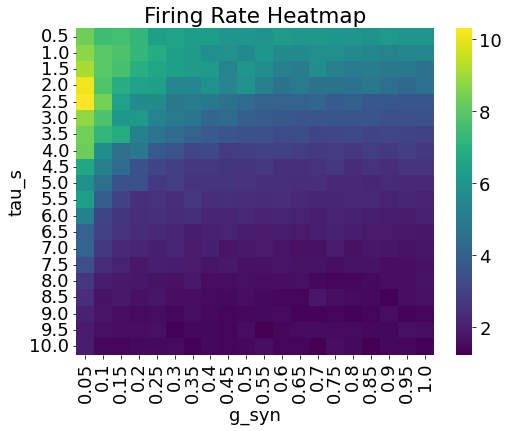

In [8]:
# COLOUR PLOT OF RATE OF FIRING WHILE VARYING TAU_S AND G_SYN
tau_s_values = np.linspace(0.5, 10, 20)
g_syn_values = np.linspace(0.05, 1, 20)

firing_rate_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        # Initialize the synaptic coupling matrix
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:
                    if np.random.rand() < connection_probability:
                        g[row, col] = g_syn

        # Initialize variables
        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t_all = np.array([t0])
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])

            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s), dense_output=True,
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.7185823035951033

                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter = spikeCounter + 1
                i_step += 1

        # Compute average firing rate
        valid_spike_times = spike_times[spike_times[:, 0] > 100]
        firing_rate = len(valid_spike_times) / (N * (T - 100)) * 1000
        firing_rate_matrix[i, j] = firing_rate

# Plot the heatmap of firing rates
plt.figure(figsize=(8, 6))
sns.heatmap(firing_rate_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=np.round(tau_s_values, 2), cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.title('Firing Rate Heatmap')
plt.show()


Average number of connections per neuron: 39.596666666666664
Connectivity Matrix g [[0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.03 0.   ... 0.   0.   0.03]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]]
Average value of matrix g= 0.003959666666666666
Chi measure (synchrony): 0.2665825157974826
Average firing rate 10.45


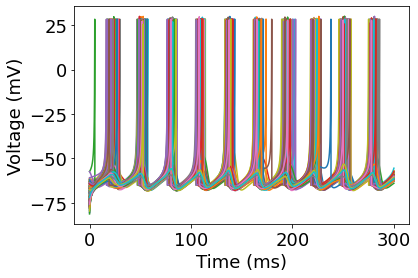

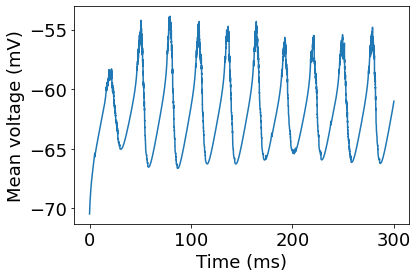

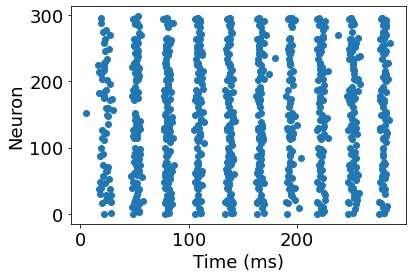

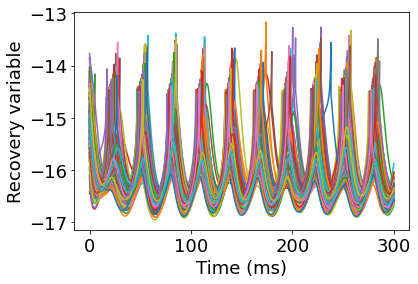

In [19]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

plt.figure()
plt.plot(t_all, y_all[:N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

plt.figure()
plt.plot(t_all, y_all[:N, :].mean(axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Mean voltage (mV)')

spike_times = spike_times[:spikeCounter, :]
plt.figure()
plt.scatter(spike_times[:, 0], spike_times[:, 1])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')

plt.figure()
plt.plot(t_all, y_all[N:2*N, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Recovery variable')



# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

In [17]:
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")
# Count the number of neurons that spiked and did not spike
num_spiked = sum(bool(times) for times in neuron_spike_times.values())
num_not_spiked = N - num_spiked

# Display the counts
print(f"Number of neurons that spiked: {num_spiked}")
print(f"Number of neurons that did not spike: {num_not_spiked}")


Neuron 0 spike times: [21.66023224477697, 48.911343111522044, 77.7315240711513, 105.33183972886036, 133.46847909629273, 162.56533674463677, 190.59514720141186, 218.69015982107703, 246.93582581644353, 275.4715722394342]
Neuron 1 spike times: [81.37433717539243, 110.27103114472754, 140.82195152104316, 222.54787864871815, 251.0498637919291, 279.8463029144284]
Neuron 2 spike times: [27.886905316326875, 110.927977495337, 138.99450590608265, 169.73722196981953, 279.7260375876486]
Neuron 3 spike times: [54.41399369210014, 223.51350659438586]
Neuron 4 spike times: [54.36804226414273, 224.3423059509395]
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: [51.50799969745386, 80.65984198465122, 110.55281173338442, 139.9907440301066, 221.5715328098199, 253.12310992230707, 282.0568344806687]
Neuron 8 spike times: []
Neuron 9 spike times: [51.21442872158724, 81.55634310707195, 109.45257384485043, 138.1062976059275, 167.315427379281, 201.63279644751168, 279.45487139795694]
Neuron 

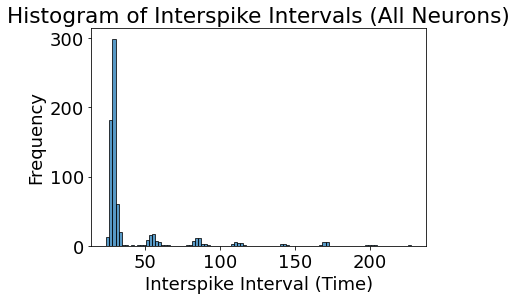

In [18]:
# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i+1] - times[i] for i in range(len(times)-1)]
# Histogram of ISIs for all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]
if all_isis:
    plt.figure()
    plt.hist(all_isis, bins=100, alpha = 0.75, edgecolor = 'k')
    plt.title("Histogram of Interspike Intervals (All Neurons)")
    plt.xlabel("Interspike Interval (Time)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No ISIs found across neurons to plot.")


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(101)

# Constants and Parameters
N = 300  # Number of neurons
T = 300  # Simulation duration
dt = 0.005  # Time step
k = 1
a, b, c, d = 0.1, 0.26, -65, -1
v_reset, v_thresh = c, 30
Esyn = -70
tauS = 3.043
g_syn = 0.03
I = 0.33
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Function to calculate dx/dt
def dxdt(t, x, k, a, b, I, Esyn, J, tauS, g):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g, s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Event function for spiking
def v_spike(t, x, k, a, b, I, Esyn, J, tauS, g):
    return np.max(x[:N]) - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Simulation
noise_variances = np.linspace(0.01, 0.5, 3)
spiking_fractions = []

for noise_var in noise_variances:
    # Initialize noise and synaptic coupling matrix
    J = np.random.normal(0, noise_var, size=(N))
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j and np.random.rand() < connection_probability:
                g[j, i] = g_syn
    
    # Initialize state variables
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size=(N))
    s_init, p_init = np.zeros(N), np.zeros(N)
    
    neuron_spike_times = {i: [] for i in range(N)}
    t0 = 0
    
    while t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])
        sol = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS, g), dense_output=True, 
                      events=v_spike, rtol=1e-8)
        
        # Handle spikes
        if len(sol.t_events[0]) > 0:
            for t_spike in sol.t_events[0]:
                spike_idx = v_init.argmax()
                neuron_spike_times[spike_idx].append(t_spike)
                v_init[spike_idx] = v_reset
                u_init[spike_idx] += d
                p_init[spike_idx] += 2.718
        
        t0 = sol.t[-1]
        v_init = sol.y[:N, -1]
        u_init = sol.y[N:2*N, -1]
        s_init = sol.y[2*N:3*N, -1]
        p_init = sol.y[3*N:4*N, -1]
    
    # Compute fraction of spiking neurons
    spiking_neurons = sum(1 for spikes in neuron_spike_times.values() if spikes)
    spiking_fractions.append(spiking_neurons / N)

# Plot results
plt.figure()
plt.plot(noise_variances, spiking_fractions, marker='o', linestyle='-')
plt.xlabel('Noise Variance')
plt.ylabel('Fraction of Neurons that Spiked')
plt.title('Noise Variance vs Fraction of Spiking Neurons')
plt.grid(True)
plt.show()


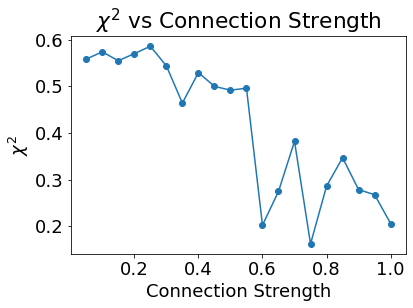

In [25]:
# CHI VS G_SYN
connection_strengths = np.linspace(0.05, 1, 20)  # Vary connection strength from 0.25 to 0.5
chi_sq_values = []

# Loop over different values of connection strength for g
for conn_strength in connection_strengths:
    # Initialize synaptic coupling matrix with new connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40/300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = conn_strength  # Set connection to the current strength value

    # Reinitialize initial conditions for each g matrix run
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current synaptic coupling matrix g
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current g matrix
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS,g), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033  # Avoid division by zero if tauS=0
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter = spikeCounter + 1
            i += 1

    # Compute chi_sq for the current g matrix
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(connection_strengths, chi_sq_values, marker='o', linestyle='-')
plt.xlabel('Connection Strength')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs Connection Strength')
plt.show()


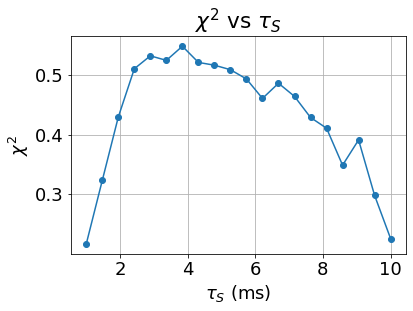

In [26]:
# Define tauS values from 1 to 10 with 20 evenly spaced points
tauS_values = np.linspace(1, 10, 20)
chi_sq_values = []

# Loop over different values of tauS
for tauS in tauS_values:
    # Initialize synaptic coupling matrix with constant connection strength
    g = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            if i != j:  # Avoid self-connections
                if np.random.rand() < 40 / 300:  # Fixed probability for connection, e.g., 0.3
                    g[j, i] = 0.03  # Keep connection strength constant at 0.03

    # Reinitialize initial conditions for each tauS value
    v_init = np.random.normal(-70, 5, size=(N))
    u_init = np.random.normal(-15, 0.5, size = (N))
    s_init = np.zeros(N)
    p_init = np.zeros(N)
    
    t_all = np.array([t0])
    y_0 = np.concatenate([v_init, u_init, s_init, p_init])
    y_all = np.reshape(y_0, (y_0.shape[0], 1))
    
    spike_times = np.zeros((M, 2))
    spikeCounter = 0
    i = 0
    t0 = 0  # Reset simulation start time

    # Simulation loop with the current tauS value
    while i < M and t0 < T:
        y0 = np.concatenate([v_init, u_init, s_init, p_init])  

        # Use solve_ivp with current tauS
        sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS,g), dense_output=True, 
                          events=v_spike, rtol=1e-8)

        t_end = sol_v.t[-1]
        steps = max([2, int((t_end - t0) / dt)])
        t = np.linspace(t0, t_end, steps)
        y = sol_v.sol(t)
        
        t_all = np.concatenate([t_all, t[:-1]], axis=0)
        y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

        t0 = t_end
        v_init = y[:N, -1]
        u_init = y[N:2*N, -1]
        s_init = y[2*N:3*N, -1]
        p_init = y[3*N:4*N, -1]

        if len(sol_v.t_events[0]) > 0:
            spike = v_init.argmax()
            v_init[spike] = v_reset
            u_init[spike] += d
            p_init[spike] += 2.7185823035951033
            
            spike_times[spikeCounter, :] = [t0, spike]
            spikeCounter += 1
            i += 1

    # Compute chi_sq for the current tauS value
    data = y_all[:N, :]
    chi_sq = compute_chi(data)
    chi_sq_values.append(chi_sq)

# Plotting the results
plt.figure()
plt.plot(tauS_values, chi_sq_values, marker='o', linestyle='-')
plt.xlabel(r'$\tau_S$ (ms)')
plt.ylabel(r'$\chi^2$')
plt.title(r'$\chi^2$ vs $\tau_S$')
plt.grid(True)
plt.show()


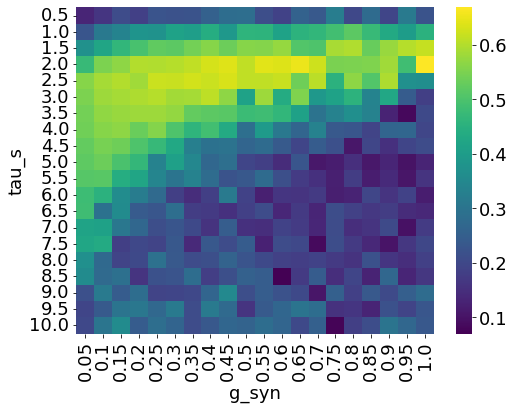

In [27]:
tau_s_values = np.linspace(0.5, 10, 20)
g_syn_values = np.linspace(0.05, 1, 20)  

chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:  
                    if np.random.rand() < connection_probability:
                        g[row, col] = g_syn  

        v_init = np.random.normal(-70, 15, size=(N))
        u_init = np.random.normal(-15, 0.5, size = (N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)
        
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))
        
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0  
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])  

            
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s, g), dense_output=True, 
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)
            
            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.7185823035951033
                
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter = spikeCounter + 1
                i_step += 1

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=tau_s_values, cmap='viridis')
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.show()


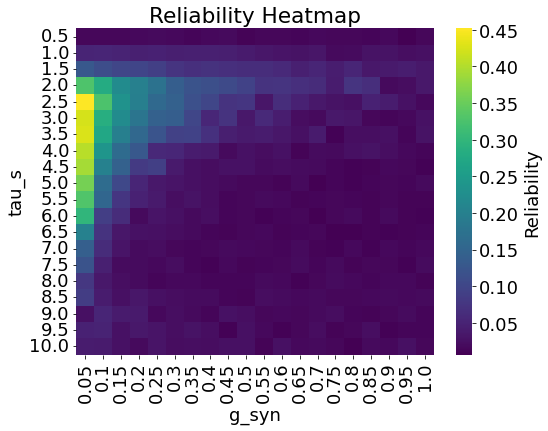

In [29]:
# NOW USING RELIABILITY MEASURE INSTEAD OF CHI

# Define parameter ranges for tau_s and g_syn
tau_s_values = np.linspace(0.5, 10, 20)
g_syn_values = np.linspace(0.05, 1, 20)
reliability_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))
num_neurons = 300
# Loop over tau_s and g_syn values
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        # Initialize synaptic coupling matrix
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col:
                    if np.random.rand() < connection_probability:
                        g[row, col] = g_syn

        # Initialize variables
        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size = (N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))

        spike_matrix = np.zeros((N, int(T / dt)))  # Binary spike matrix for reliability calculation

        spikeCounter = 0
        t0 = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])

            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s, g), dense_output=True,
                              events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += 2.7185823035951033

                spike_matrix[int(spike), int(t0 / dt)] = 1  # Record spike
                spikeCounter += 1
                i_step += 1

        # Compute reliability for the current tau_s and g_syn
        t = np.linspace(0, T, spike_matrix.shape[1])  # Time vector for reliability calculation
        reliability, _ = compute_Reliability(spike_matrix, t, tau_s)
        reliability_matrix[i, j] = reliability

# Plotting the reliability heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(reliability_matrix, xticklabels=np.round(g_syn_values, 2), yticklabels=np.round(tau_s_values, 2),
            cmap='viridis', cbar_kws={'label': 'Reliability'})
plt.xlabel('g_syn')
plt.ylabel('tau_s')
plt.title('Reliability Heatmap')
plt.show()


In [ ]:
g_syn_values = np.linspace(0.5,10,20)
print(g_syn_values)